In [1]:
#import libraries
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import pathlib

In [2]:
#download and explore
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file('flower_photos',origin=dataset_url,untar=True)
data_dir=pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [3]:
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


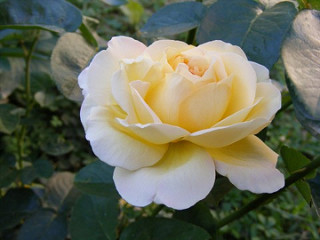

In [4]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[8]))

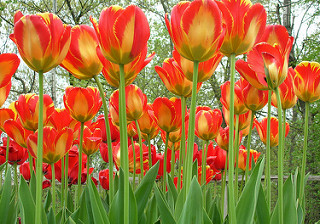

In [5]:
tulips=list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

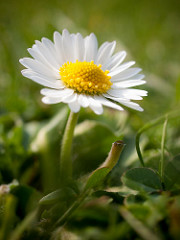

In [6]:
daisy=list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[5]))

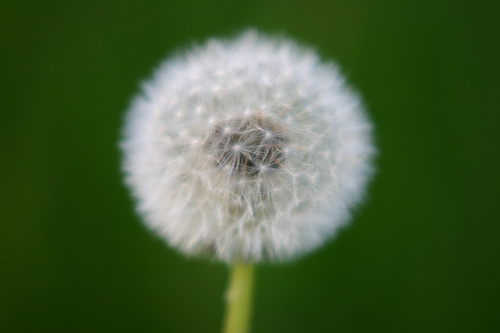

In [7]:
dandelion=list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[25]))

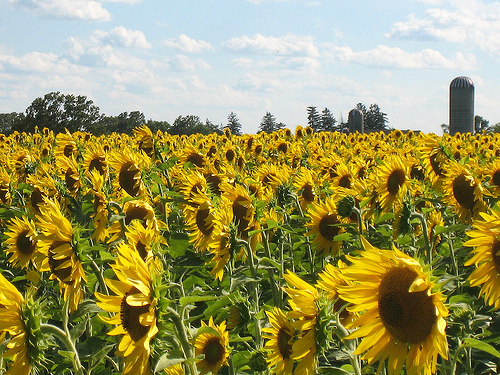

In [8]:
sunflowers=list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[1]))

In [9]:
#load using keras.preprocessing
batch_size=32
img_height=180
img_width=180

In [10]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


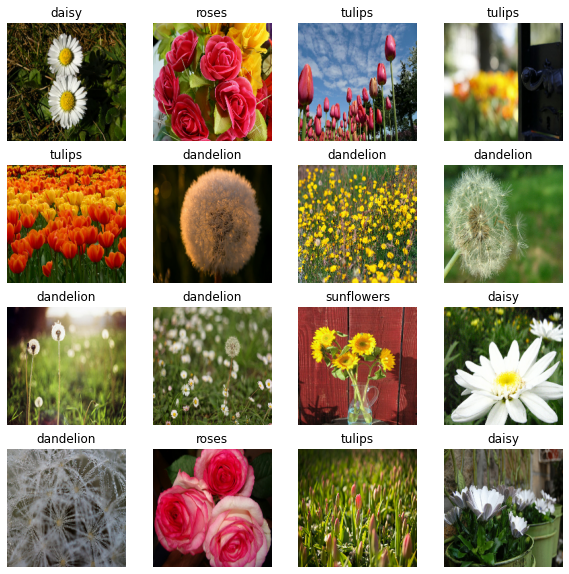

In [13]:
#visualize the data
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(2):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
#configure the dataset for performance
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#standardize the data
normalization_layer=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds=train_ds.map(lambda x,y :(normalization_layer(x),y))
image_batch,labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [18]:
#create the model
num_classes=5
model=tf.keras.Sequential([
                  tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                  tf.keras.layers.Conv2D(16,3,padding='same',activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(128,activation='relu'),
                  tf.keras.layers.Dense(num_classes)

])

In [19]:
#Compile the model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [20]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [21]:
#train the model
epochs=10
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
92/92 [==============================] - 90s 970ms/step - loss: 1.5621 - accuracy: 0.3149 - val_loss: 1.1978 - val_accuracy: 0.5027
Epoch 2/10
92/92 [==============================] - 88s 955ms/step - loss: 1.0475 - accuracy: 0.5833 - val_loss: 0.9780 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 88s 952ms/step - loss: 0.8068 - accuracy: 0.6844 - val_loss: 0.9611 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 87s 943ms/step - loss: 0.6116 - accuracy: 0.7760 - val_loss: 0.9262 - val_accuracy: 0.6676
Epoch 5/10
92/92 [==============================] - 87s 950ms/step - loss: 0.3891 - accuracy: 0.8688 - val_loss: 1.1644 - val_accuracy: 0.6240
Epoch 6/10
92/92 [==============================] - 89s 963ms/step - loss: 0.2213 - accuracy: 0.9304 - val_loss: 1.2518 - val_accuracy: 0.6199
Epoch 7/10
92/92 [==============================] - 88s 955ms/step - loss: 0.1384 - accuracy: 0.9582 - val_loss: 1.4938 - val_accuracy: 0.6444

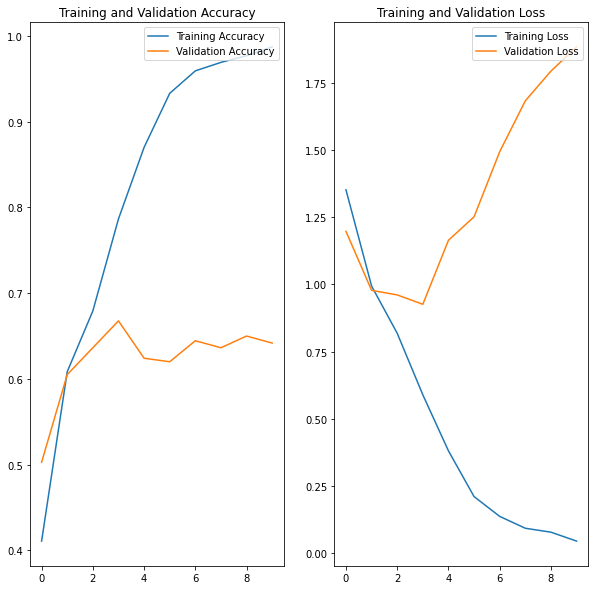

In [22]:
#visualize training results
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

In [23]:
#Overfitting: In the plots above the training accuracy is increasing linearly over time,whereas validation accuracy stalls around 60% in the training process.
#the difference in accuracy between training and validation accuracy is noticable a sign of overfitting.

In [24]:
#data augmentation
data_augmentation=tf.keras.Sequential([
                                       
                                       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
                                       tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
                                       tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

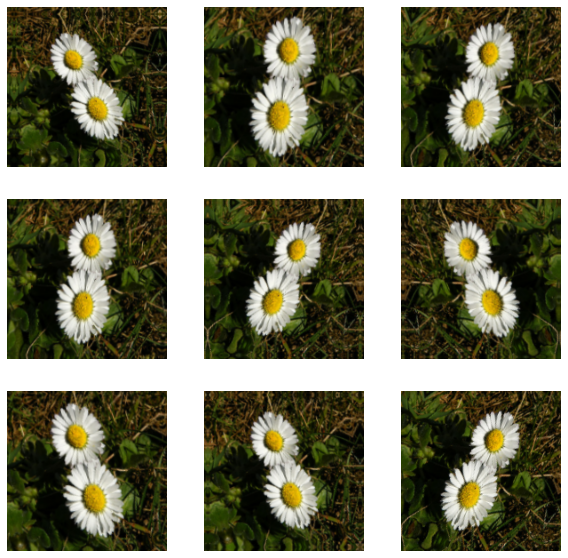

In [25]:
plt.figure(figsize=(10,10))
for image, _ in train_ds.take(1):
  for i in range(9):
    augmented_images=data_augmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
#dropout
model=tf.keras.Sequential([
                  data_augmentation,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                  tf.keras.layers.Conv2D(16,3,padding='same',activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(128,activation='relu'),
                  tf.keras.layers.Dense(num_classes)
])

In [32]:
#compile and train the model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [34]:
epochs=15
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/15
92/92 [==============================] - 103s 1s/step - loss: 1.5046 - accuracy: 0.3223 - val_loss: 1.0755 - val_accuracy: 0.5668
Epoch 2/15
92/92 [==============================] - 102s 1s/step - loss: 1.0608 - accuracy: 0.5788 - val_loss: 1.0375 - val_accuracy: 0.5899
Epoch 3/15
92/92 [==============================] - 101s 1s/step - loss: 0.9584 - accuracy: 0.6196 - val_loss: 0.9464 - val_accuracy: 0.6281
Epoch 4/15
92/92 [==============================] - 102s 1s/step - loss: 0.8501 - accuracy: 0.6654 - val_loss: 0.8760 - val_accuracy: 0.6771
Epoch 5/15
92/92 [==============================] - 102s 1s/step - loss: 0.7704 - accuracy: 0.6859 - val_loss: 0.9148 - val_accuracy: 0.6744
Epoch 6/15
92/92 [==============================] - 102s 1s/step - loss: 0.7427 - accuracy: 0.7070 - val_loss: 0.7738 - val_accuracy: 0.6935
Epoch 7/15
92/92 [==============================] - 102s 1s/step - loss: 0.7312 - accuracy: 0.7242 - val_loss: 0.7694 - val_accuracy: 0.6935
Epoch 8/15
92

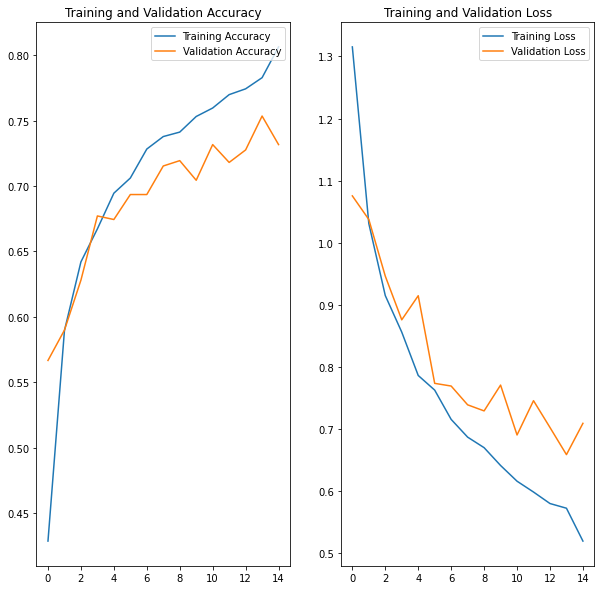

In [35]:
#visualize training results
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

114688/111735 [==============================] - 0s 2us/step
This image most likely belongs to dandelion with a 99.97 percent confidence.


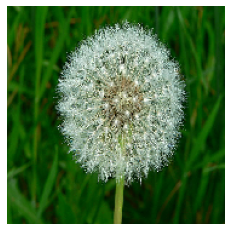

In [45]:
sunflower_url = "https://www.foragelondon.co.uk/wp-content/uploads/2015/03/Greg-Hume.jpg"
sunflower_path = tf.keras.utils.get_file('Dandelion', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


plt.imshow(img)
plt.axis('off')

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)